In [7]:
import pandas as pd
import re
import numpy as np
import nltk
import pickle 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize

### Read txt file

In [8]:
df_data = pd.read_csv('data.csv', encoding='latin')
df_abuse = pd.read_csv('abusive.csv', encoding='latin')
df_alay = pd.read_csv('new_kamusalay.csv', names = ['Kata alay','Kata ganti'], encoding='latin')
df_stop = pd.read_csv('stopwordbahasa.csv', names = ['stopword'])

col_names = ['Text','Sentiment']
df_train = pd.read_csv('train_preprocess.tsv.txt', on_bad_lines = 'skip', names = col_names, sep = '\t') 

In [9]:
temp_df = df_data #Assign to a new variable for testing
temp_df1 = df_data #test variable

In [10]:
df_data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [11]:
df_data[182:184]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
182,USER USER USER USER USER USER USER USER USER U...,0,0,0,0,0,0,0,0,0,0,0,0
183,#MukidiKepedean ; Pertanyaan mudah ya..; Dijaw...,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
df_train.head()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [13]:
temp_df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [14]:
df_abuse

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing
...,...
120,rezim
121,sange
122,serbet
123,sipit


In [15]:
df_alay

,Kata alay,Kata ganti
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [16]:
df_stop

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
753,wong
754,yaitu
755,yakin
756,yakni


#### Analysis

In [17]:
temp_df.shape

(13169, 13)

In [18]:
temp_df.info() #no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       11000 non-null  object
 1   Sentiment  11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


## Cleansing, Tokenize function

In [20]:
def remove_chars(text):
    text = re.sub(r'[^a-zA-Z0-9]',' ', str(text)) #convert to string to be able to replace
    text = text.lower() #lowercase all text
    text = text.strip() #strip trailing or leading characters
    text = re.sub('\n', ' ', text) #remove \n
    text = re.sub('user',' ', text) #remove user
    text = re.sub('https\S+','',text) #remove links and whitespaces
    text = re.sub('(rt) | (RT)',' ',text) #remove RTs
    text = re.sub('  +',' ', text) #remove space lebih
    text = re.sub('USER',' ',text) #remove the word user
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split()) #remove hashtags, @, links
    text = re.sub('tweet',' ',text) #remove tweet
    text = re.sub('hs',' ',text) #remove hs
    text = re.sub('abusive',' ',text) #remove abusive
    text = re.sub('x[a-z0-9]{2}',' ',text) #remove emoticons
    text = re.sub(';',' ',text)
    text = re.sub(':',' ',text)
    return text

alay_dict = dict(zip(df_alay['Kata alay'], df_alay['Kata ganti']))

def clean_alay(text):
    return ' '.join([alay_dict[alay] if alay in alay_dict else alay for alay in text.split(' ')])

def clean_stop(text):
    text = ' '.join(['' if stop in df_stop.stopword.values else stop for stop in text.split(' ')])
    text = text.strip() #strip trailing or leading characters
    text = re.sub('  +',' ', text) #remove space lebih
    return text

#try removing early spaces
def clean_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

In [21]:
def full_clean(text):
    text = remove_chars(text)
    text = clean_alay(text)
    text = clean_stop(text)
    #text = clean_space(text)
    return text

In [22]:
df_train

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


### Data and label sorting

In [23]:
neg = df_train.loc[df_train['Sentiment'] == 'negative'].Text.tolist()
neu = df_train.loc[df_train['Sentiment'] == 'neutral'].Text.tolist()
pos = df_train.loc[df_train['Sentiment'] == 'positive'].Text.tolist()

neg_label = df_train.loc[df_train['Sentiment'] == 'negative'].Sentiment.tolist()
neu_label = df_train.loc[df_train['Sentiment'] == 'neutral'].Sentiment.tolist()
pos_label = df_train.loc[df_train['Sentiment'] == 'positive'].Sentiment.tolist()

In [24]:
new_data = neg + neu + pos
labels = neg_label + neu_label + pos_label

print('pos: %s, neu: %s, neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(new_data))

pos: 6416, neu: 1148, neg: 3436
Total data: 11000


## Feature extraction (TF_IDF)

In [25]:
max_features = 100000
tokenizer = Tokenizer(num_words = max_features, split = ' ', lower = True)
tokenizer.fit_on_texts(new_data)
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print('tokenizer function is saved')

X = tokenizer.texts_to_sequences(new_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(X) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
    pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print('pad sequences function is saved')

tokenizer function is saved
pad sequences function is saved


In [26]:
Y =pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle','wb') as handle:
    pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print('y_label is saved')

y_label is saved


## Train test split

In [27]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_test, X_train, y_test, y_train = train_test_split(X, Y, test_size = 0.2, random_state=True, stratify=Y)

#Pake stratify untuk menyamakan proporsi test size dengan proporsi label data. 

## Start training 

In [28]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K 

In [29]:
#tambah parameter patience, walaupun perbandingan antar epoch kecil tapi tetep lanjut sesuai ankga yg kita set.

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(LSTM(units, dropout = 0.2))
model.add(Dense(3, activation = 'softmax'))

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_data = (X_test, y_test), verbose = 1, callbacks = [es])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


220/220 [==============================] - 45s 198ms/step - loss: 0.6520 - accuracy: 0.7250 - val_loss: 0.5165 - val_accuracy: 0.7778
Epoch 2/10
220/220 [==============================] - 46s 207ms/step - loss: 0.3083 - accuracy: 0.8964 - val_loss: 0.4436 - val_accuracy: 0.8372
Epoch 3/10
220/220 [==============================] - 48s 218ms/step - loss: 0.1413 - accuracy: 0.9527 - val_loss: 0.5809 - val_accuracy: 0.8198
Epoch 4/10
220/220 [==============================] - 48s 219ms/step - loss: 0.0735 - accuracy: 0.9759 - val_loss: 0.4972 - val_accuracy: 0.8380
Epoch 5/10
220/220 [==============================] - 45s 205ms/step - loss: 0.0365 - accuracy: 0.9873 - val_loss: 0.5748 - val_accuracy: 0.8359
Epoch 5: early stopping


## Evaluation

In [31]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
print('Report: ')
print(matrix_test)


275/275 [==============================] - 8s 14ms/step
Report: 
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      2749
           1       0.84      0.61      0.70       918
           2       0.86      0.93      0.89      5133

    accuracy                           0.84      8800
   macro avg       0.83      0.76      0.79      8800
weighted avg       0.83      0.84      0.83      8800



### Cross validation

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
#tambah parameter patience, walaupun perbandingan antar epoch kecil tapi tetep lanjut sesuai ankga yg kita set.

kf = KFold(n_splits = 5, random_state= 42, shuffle = True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start = 1):

    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
    model.add(LSTM(units, dropout = 0.2))
    model.add(Dense(3, activation = 'softmax'))

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 3)
    history = model.fit(X_train, y_train, epochs = 10, batch_size = 10, validation_data =(X_test, y_test), verbose = 0, callbacks = [es])

    predictions = model.predict(X_test)

    y_pred = predictions

    #accuracy for current fold
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print('Training ke-', iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('------------------------------------------------------')

    accuracies.append(accuracy)

#average accuracy of folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print('rata-rata accuracy: ', average_accuracy)


275/275 [==============================] - 4s 13ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2749
           1       0.80      0.64      0.71       918
           2       0.88      0.89      0.89      5133

    accuracy                           0.83      8800
   macro avg       0.81      0.77      0.79      8800
weighted avg       0.83      0.83      0.83      8800

------------------------------------------------------
275/275 [==============================] - 4s 13ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      2749
           1       0.77      0.64      0.70       918
           2       0.88      0.89      0.89      5133

    accuracy                           0.83      8800
   macro avg       0.80      0.77      0.79      8800
weighted avg       0.83      0.83      0.83      8800

-----------------------------------------

## Viz

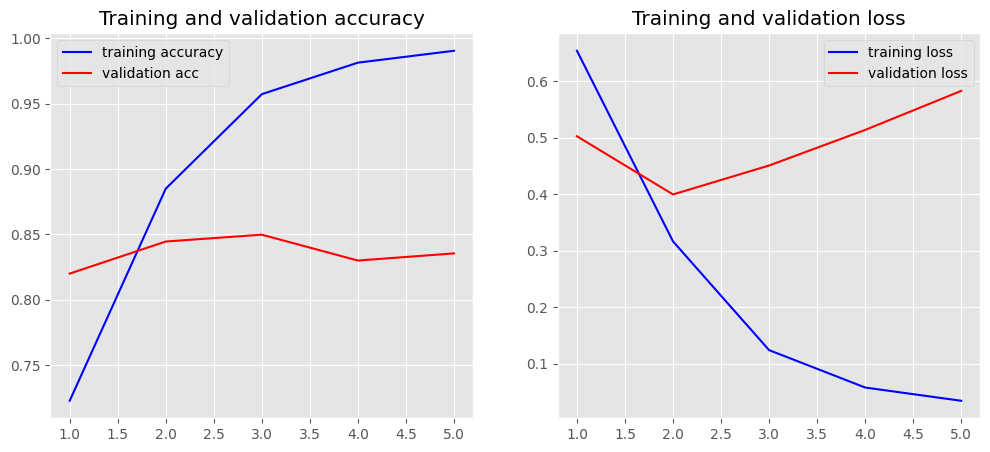

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize = (12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label = 'training accuracy')
    plt.plot(x, val_acc, 'r', label = 'validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'training loss')
    plt.plot(x, val_loss, 'r', label = 'validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
%matplotlib inline
plot_history(history)




In [32]:
model.save('model_sentiment.h5')
print('model saved')

model saved


## Predict with new data

### Explore data

In [27]:
df_list1 = []
for i, k in temp_df.iterrows():
    df_list1.append(k['Tweet'])
    
temp_df['Tweet'] = df_list1
df_list1

["- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'",
 "RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'",
 '41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter',
 "USER USER AKU ITU AKU\\n\\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU'",
 "USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah'",
 "USER Ya bani taplak dkk \\xf0\\x9f\\x98\\x84\\xf0\\x9f\\x98\\x84\\xf0\\x9f\\x98\\x84'",
 'deklarasi pilkada 2018 aman dan anti hoax warga dukuh sari jabon',
 'Gue baru aja kelar re-watch Aldnoah Zero!!! paling kampret emang endingnya! 2 karakter utama cowonya kena friendzone bray! XD URL',
 'Na

## Cleanse and FE input data

In [29]:
#create new column to see the difference
temp_df['Tweet_cleansed'] = temp_df['Tweet'].apply(full_clean)
cleansed_df = temp_df[['Tweet','Tweet_cleansed']]
cleansed_df

,Tweet,Tweet_cleansed
0,- disaat semua cowok berusaha melacak perhatia...,cowok berusaha melacak perhatian gue lantas re...
1,RT USER: USER siapa yang telat ngasih tau elu?...,telat tau edan sarap gue bergaul cigax jifla c...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang berpikir percaya tuhan jatuh berkali...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,ku tau matamu sipit
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir dongoknya dungu haha
...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,berbicara ndasmu congor sekata anjing
13165,USER Kasur mana enak kunyuk',kasur enak kunyuk
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,hati hati bisu bosan duh
13167,USER USER USER USER Bom yang real mudah terdet...,bom real mudah terdeteksi bom terkubur yat led...


In [30]:
#Convert clean data into list

df_list = []
for i, k in temp_df.iterrows():
    df_list.append(full_clean(k['Tweet']))
    
temp_df['Tweet_cleansed'] = df_list
df_list

['cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego',
 'telat tau edan sarap gue bergaul cigax jifla calis licew',
 '41 kadang berpikir percaya tuhan jatuh berkali kali kadang tuhan meninggalkan orang tuaku berencana berpisah kakakku memilih kristen anak ter',
 'ku tau matamu sipit',
 'kaum cebong kafir dongoknya dungu haha',
 'ya bani taplak kawan kawan',
 'deklarasi pilihan kepala daerah 2018 aman anti hoaks warga dukuh sari jabon',
 'gue selesai re watch aldnoah zero kampret 2 karakter utama cowoknya kena friendzone bro xd uniform resource locator',
 'admin belanja po terbaik nak makan ais kepal milo ais kepal horlicks cendol toping kau kau doket gerai rozak mertuaku taipan 2 kembar baby amp romantika bank islam senawang',
 'enak ngewe',
 'gue jari gue ukur nyali bacot',
 'banci kaleng malu 2 nyungsep koe uniform resource locator',
 'belajar ekonomi mestinya jago memprivatisasi hati orang aduh ironi',
 'aktor huru hara 98 prabowo si len

In [31]:
#change from list to dataframe
twt = pd.DataFrame(df_list, columns = ['twt'])

In [32]:
twt

,twt
0,cowok berusaha melacak perhatian gue lantas re...
1,telat tau edan sarap gue bergaul cigax jifla c...
2,41 kadang berpikir percaya tuhan jatuh berkali...
3,ku tau matamu sipit
4,kaum cebong kafir dongoknya dungu haha
...,...
13164,berbicara ndasmu congor sekata anjing
13165,kasur enak kunyuk
13166,hati hati bisu bosan duh
13167,bom real mudah terdeteksi bom terkubur yat led...


## Try model

In [33]:
from keras.models import load_model

In [34]:
i = len(df_list)
i

13169

## Predict

In [35]:
#Try predict sentiment on a list
result1 = []
result2 = []
df_list1 = df_list[:100]
sentiment = ['positive', 'neutral', 'negative']

for i in df_list1:
    predicted = tokenizer.texts_to_sequences(i)
    guess = pad_sequences(predicted, maxlen = X.shape[1])
    prediction = model.predict(guess)
    polarity = np.argmax(prediction[0])
    result1.append(i)
    result2.append(sentiment[polarity])

#df1 = pd.concat([result1, result2], axis = 1)
df_df = pd.DataFrame({'Text' : result1, 'Sentiment': result2})
df_df

2/2 [==============================] - 0s 11ms/step


,Text,Sentiment
0,cowok berusaha melacak perhatian gue lantas re...,positive
1,telat tau edan sarap gue bergaul cigax jifla c...,negative
2,41 kadang berpikir percaya tuhan jatuh berkali...,neutral
3,ku tau matamu sipit,negative
4,kaum cebong kafir dongoknya dungu haha,negative
...,...,...
95,salah target ahok agenda utama lengserkan jokowi,negative
96,kena tagar kepanasan banget 2019 ganti presiden,negative
97,maju duit goyang kaki pape duit nak maju kat b...,positive
98,huria kristen batak protestan berdiri pecahnya...,negative


In [30]:
#ngecek sebelom di drop, rows yang kosong isinya
twt[182:184]

NameError: name 'twt' is not defined

In [ ]:
twt = twt.drop_duplicates()

In [ ]:
#ngeliat rows mana aja yang kosong
twt = twt.sort_values(['tweets'], ascending=True)
twt

In [ ]:
#drop index ke 182, dan reset index
twt = twt.drop(index = 182).reset_index(drop = True)

In [ ]:
twt

In [35]:
#Try predict sentiment in the form of dataframe
result1 = []
result2 = []
df_data1 = twt['tweets']
sentiment = ['positive', 'neutral', 'negative']

for i in  df_data1:
    predicted = tokenizer.texts_to_sequences(i)
    guess = pad_sequences(predicted, maxlen = X.shape[1])

    model = load_model('model_sentiment.h5')
    prediction = model.predict(guess)
    polarity = np.argmax(prediction[0])
    result1.append(i)
    result2.append(sentiment[polarity])

#df1 = pd.concat([result1, result2], axis = 1)
df_df = pd.DataFrame({'Text' : result1, 'Sentiment': result2})
df_df

2/2 [==============================] - 0s 13ms/step


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.